March 2022

Figure 5 and SI Fig. 4.

This notebook concerns the evaluation of networks trained to match Mante's monkey A data with an unconstrained initial period during which the network is free to attain the data's initial points.

A rank one network can do the task. It appears most of its neurons can be safely removed (not useful to the task). Among the rest, a very limited number of them seem to be absolutely critical (in the sense that removing only one totally destroys the network's functioning). Using the network monkeyA_22 for the final version.

Trained with mante_fit_lowrank.py

In [1]:
import sys
sys.path.append('../')

from scipy.io import loadmat
from scipy.stats import kurtosis
from glob import glob
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from low_rank_rnns import plotting as plot, stats, helpers, mante, ranktwo, clustering
from low_rank_rnns import data_loader_mante as dlm
from low_rank_rnns.modules import *
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
plot.setup_matplotlib()
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 22

In [3]:
%%time
bin_width = 5
smoothing_width = 50

dataset = dlm.ManteDataset(monkey='A', bin_width=bin_width, smoothing_width=smoothing_width, cavg=True)

Loading data for monkey A
loaded 762 units, binned at 5.0ms
Averaging over 144 conditions
CPU times: user 42.7 s, sys: 8.68 s, total: 51.4 s
Wall time: 1min 18s


In [4]:
# Selecting neurons that have at least one trial for each correct condition
correct_trials = dataset.conditions.correct == 1
good_neurons = ~np.any(dataset.ntrials[correct_trials] == 0, axis=0)
print(good_neurons.sum())
neurons_map_orig = np.where(good_neurons)[0]

# X_all is the data averaged tensor for "valid neurons", X is the same tensor with only non-error trials
X_all = dataset.data_avg[:, :, good_neurons]
X = dataset.data_avg[correct_trials][:, :, good_neurons]
print(X.shape)

727
(72, 150, 727)


In [5]:
n_neurons = X.shape[-1]
print(n_neurons)
nconds = X.shape[0]
print(nconds)
ntime = X.shape[1]
print(ntime)

727
72
150


In [6]:
choice = dataset.conditions[correct_trials]['choice']
context = dataset.conditions[correct_trials]['context']
direction = dataset.conditions[correct_trials]['stim_dir_lvl']
color = dataset.conditions[correct_trials]['stim_col_lvl']

In [7]:
# Denoise data
X_flat = helpers.flatten_trajectory(X)
X_mean = np.mean(X_flat, axis=0)  # Removing the per-neuron mean before denoising
X_flat = (X_flat - X_mean)
pca_std = stats.pca_fit(X_flat, n_components=50)
denoise_mat = pca_std.components_[:12]
X_den = X_flat @ denoise_mat.T @ denoise_mat   # Projection on the top-12 components subspace
X_den_unflat = helpers.unflatten_trajectory(X_den, nconds)
# X_den_tot = X_den_unflat + X_mean   # Re-adding the mean

# np.save('../data/X_den_monkeyA.npy', X_den_unflat)

In [8]:
# Perform linear regression
conditions_regressors = dataset.conditions[correct_trials][['choice', 'stim_dir', 'stim_col', 'context']].to_numpy()
X_den_percond = X_den_unflat.reshape((nconds, -1))
print(conditions_regressors.shape)
print(X_den_percond.shape)
# Linear regression
linmodel = LinearRegression(fit_intercept=True)
linmodel = linmodel.fit(conditions_regressors, X_den_percond)
betas = linmodel.coef_.T.reshape((4, ntime, -1))
intercepts = linmodel.intercept_.T.reshape((ntime, -1))
betas = np.concatenate([betas, intercepts[np.newaxis, :, :]], axis=0)
print(betas.shape)

# Denoise betas
betas = betas @ denoise_mat.T @ denoise_mat

# Data without the time component
X_cent = X_den_unflat - betas[-1]

mean_abs_act = np.abs(X_cent).mean(axis=(0,1))

# np.save('../data/X_cent_monkeyA.npy', X_cent)
# dataset.conditions.to_csv('../data/conditions_monkeyA.csv')

(72, 4)
(72, 109050)
(5, 150, 727)


(727, 4)


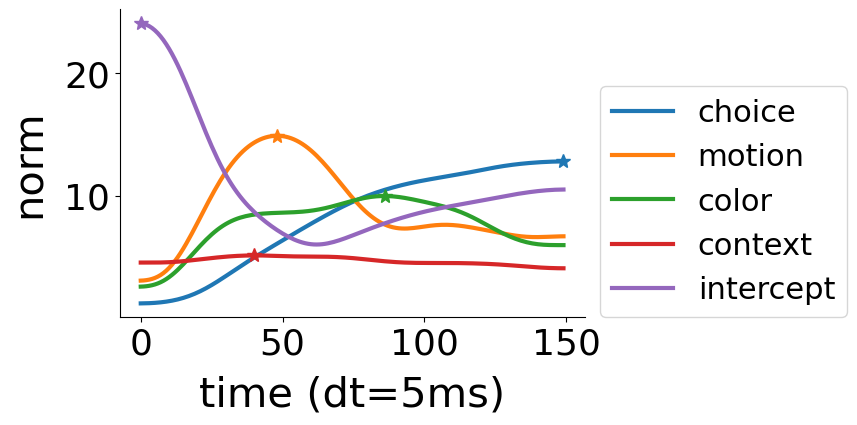

In [9]:
%matplotlib inline

# print norm of the vectors and identify t_max, define TDR orthogonalized axes
tmaxes = []
labels = ['choice', 'motion', 'color', 'context', 'intercept']
for i in range(5):
    norms = np.linalg.norm(betas[i], axis=1)
    p, = plt.plot(norms, label=labels[i], lw=3)
    tmaxes.append(np.argmax(norms))
    plt.plot([tmaxes[-1]], [norms[tmaxes[-1]]], marker='*', c=p.get_color(), markersize=10)
plt.legend(bbox_to_anchor=(1, .8))
plt.ylabel('norm')
plt.xlabel('time (dt=5ms)')

# Choose timepoints for the axes, orthogonalize
beta_choice = betas[0, tmaxes[0]]
beta_motion = betas[1, tmaxes[1]]
beta_color = betas[2, tmaxes[2]]
beta_context = betas[3, tmaxes[3]]
Bmat = np.vstack([beta_choice, beta_motion, beta_color, beta_context]).T
print(Bmat.shape)
BmatQ, _ = np.linalg.qr(Bmat)
beta_choice = BmatQ[:, 0]
beta_motion = BmatQ[:, 1]
beta_color = BmatQ[:, 2]
beta_context = BmatQ[:, 3]

# np.save('../data/beta_axes_monkeyA.npy', BmatQ)

In [10]:
X_lin = X_cent @ BmatQ @ BmatQ.T  # X_lin is the activity projected on only the 4 beta axes
X_lin.shape
# np.save('../data/X_lin_monkeyA.npy', X_lin)

(72, 150, 727)

# Prepare inputs

In [11]:
# Prepare pseudo-inputs
mante.fixation_duration = 0
mante.ctx_only_pre_duration = 350 # changed from 100 to 350 on 05.05 (#22)
mante.stimulus_duration = 650   # adjusted to account for initial state of the network (1st step doesn't count)
mante.delay_duration = 95
mante.decision_duration = 5
mante.deltaT = bin_width
mante.SCALE = 1
mante.SCALE_CTX = 1
mante.setup()

inputs, targets_task, mask_task = mante.generate_mante_data_from_conditions(dataset.conditions[correct_trials]['stim_dir'].to_numpy(),
                                                         dataset.conditions[correct_trials]['stim_col'].to_numpy(),
                                                         context.to_numpy())

hidden_neurons = 0
size = n_neurons + hidden_neurons

coherences = np.unique(dataset.conditions[correct_trials]['stim_dir'].to_numpy())
coherences

array([-0.5       , -0.14998688, -0.04700787,  0.04700787,  0.14998688,
        0.5       ])

# Testing full-rank model

In [12]:
hidden_neurons = 0


size = n_neurons + hidden_neurons
net_fr = FullRankRNN(4, size, n_neurons, 0, 0.2, output_non_linearity=(lambda x: x))
net_fr.load_state_dict(torch.load('../models/mante_monkeyA_subspace_22.pt'))

<All keys matched successfully>

In [13]:
_, traj_fr = net_fr(inputs, return_dynamics=True)
traj_fr = traj_fr.detach().numpy()[:, mante.ctx_only_pre_duration_discrete+1:, :][:, :, :n_neurons]

In [14]:
r2_global_fr = stats.r2_score(X_cent.ravel(), traj_fr.ravel())
print(f'R2 global: {r2_global_fr}')
print(f'R2 per neuron mean: {stats.r2_idneurons(X_cent, traj_fr)}')

R2 global: 0.7371898847729588
R2 per neuron mean: -17.366343504655084


In [15]:
r2s = np.array(stats.r2_idneurons(X_cent, traj_fr, return_all=True))
print(f'R2 per neuron median: {np.median(r2s)}')
r2_median_fr = np.median(r2s)

R2 per neuron median: 0.5150807976501717


In [16]:
decisions = np.sign((traj_fr @ beta_choice)[:, -1])
acc_fr = (choice.values == -decisions).sum() / 72
print(acc_fr)

1.0


/Users/avalente/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-1.0, 1.0)

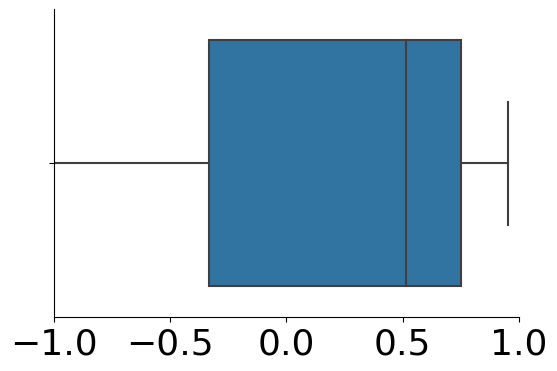

In [17]:
sns.boxplot(r2s)
plt.xlim(-1, 1)

/Users/avalente/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'R2')

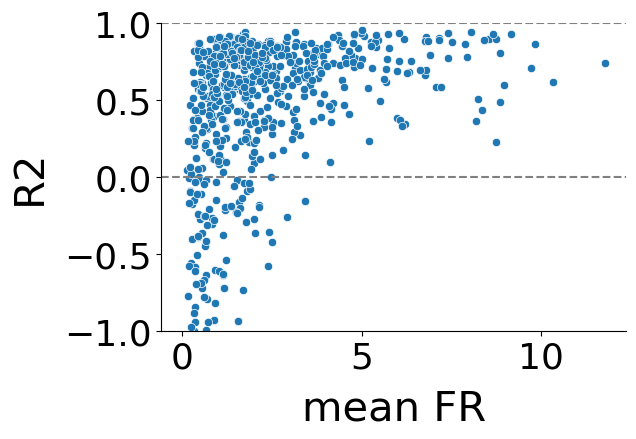

In [18]:
sns.scatterplot(X_mean, r2s)
plt.ylim(-1, 1)
plt.axhline(0, c='gray', ls='--')
plt.axhline(1, c='gray', ls='--')
plt.xlabel('mean FR')
plt.ylabel('R2')

# Testing low-rank models

In [19]:
r2s_glob = []
r2s_medians = []
accs = []

ranks = list(range(1, 6))
for rank in ranks:
    net = LowRankRNN(4, size, n_neurons, 0, 0.2, rank=rank, output_non_linearity=(lambda x: x))
    net.load_state_dict(torch.load(f'../models/mante_monkeyA_subspace_rank{rank}_22.pt'))
    _, traj = net(inputs, return_dynamics=True)
    # traj = net.non_linearity(traj)
    traj = traj.detach().numpy()[:, mante.ctx_only_pre_duration_discrete+1:, :][:, :, :n_neurons]
    
    r2s_glob.append(stats.r2_score(X_cent.ravel(), traj.ravel()))
    print(f'Rank {rank}, test R2 global: {r2s_glob[-1]}')
    
    r2s_all = stats.r2_idneurons(X_cent, traj, return_all=True)
    print(f'Rank {rank}, test R2 per neuron mean: {np.mean(r2s_all)}')
    r2s_medians.append(np.median(r2s_all))
    print(f'Rank {rank}, test R2 per neuron median: {r2s_medians[-1]}')
    
    decisions = np.sign((traj @ beta_choice)[:, -1])
    acc = (choice.values == -decisions).sum() / 72
    print(f'Rank {rank}, accuracy: {acc:.2f}')
    accs.append(acc)

Rank 1, test R2 global: 0.6645647009158666
Rank 1, test R2 per neuron mean: -0.881740684676692
Rank 1, test R2 per neuron median: 0.6438633002144102
Rank 1, accuracy: 1.00
Rank 2, test R2 global: 0.6632753138352527
Rank 2, test R2 per neuron mean: -2.1247133693044167
Rank 2, test R2 per neuron median: 0.6436551133645161
Rank 2, accuracy: 1.00
Rank 3, test R2 global: 0.6662839720743912
Rank 3, test R2 per neuron mean: -1.8620232435394621
Rank 3, test R2 per neuron median: 0.6396716873992363
Rank 3, accuracy: 0.99
Rank 4, test R2 global: 0.6786241888943179
Rank 4, test R2 per neuron mean: 0.22914217417371824
Rank 4, test R2 per neuron median: 0.6357366821693589
Rank 4, accuracy: 1.00
Rank 5, test R2 global: 0.6804448092604231
Rank 5, test R2 per neuron mean: 0.39078720153626806
Rank 5, test R2 per neuron median: 0.6336235878510383
Rank 5, accuracy: 0.96


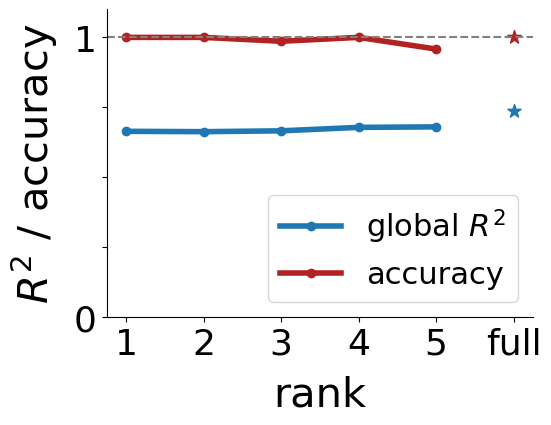

In [20]:
plt.figure(figsize=(5.5, 4))
# plt.plot(ranks, r2s_glob, marker='o', label='global', c='tab:blue', lw=3, markersize=9)
plt.plot(ranks, r2s_glob, marker='o', c='tab:blue', label='global $R^2$', lw=4)
plt.plot(ranks, accs, marker='o', c='firebrick', label='accuracy', lw=4)
plt.scatter([6], [r2_global_fr], color='tab:blue', marker='*', s=100)
plt.scatter([6], [acc_fr], color='firebrick', marker='*', s=100)
plt.ylim(0, 1.1)
plt.yticks(np.arange(0, 1.1, 0.25))
plt.gca().set_yticklabels([0, '', '', '', 1])
plt.xticks([1, 2, 3, 4, 5, 6])
plt.gca().set_xticklabels([1, 2, 3, 4, 5, 'full'])
plt.legend(loc='lower right')
plt.xlabel('rank')
plt.ylabel('$R^2$ / accuracy')
plt.axhline(1, ls='--', c='gray')
# plt.savefig('../figures/neurips/r2_monkeyA.pdf', bbox_inches='tight')

# Looking at the rank 1 network

In [21]:
rank = 1
net = LowRankRNN(4, size, n_neurons, 0, 0.2, rank=rank, output_non_linearity=(lambda x: x))
net.load_state_dict(torch.load(f'../models/mante_monkeyA_subspace_rank{rank}_22.pt'))
outp, traj = net(inputs, return_dynamics=True)
traj_tot = traj.detach().numpy()[:, :, :n_neurons]
traj = traj.detach().numpy()[:, mante.ctx_only_pre_duration_discrete+1:, :][:, :, :n_neurons]

decisions = np.sign((traj @ beta_choice)[:, -1])
acc = (choice.values == -decisions).sum() / 72
print(acc)

1.0


In [22]:
net.svd_reparametrization()

In [23]:
wis = [net.wi_full[i].detach().numpy() for i in range(4)]
ms = [net.m[:, i].detach().numpy() for i in range(rank)]
ns = [net.n[:, i].detach().numpy() for i in range(rank)]


wi1 = net.wi_full[0].detach().numpy()
wi2 = net.wi_full[1].detach().numpy()
wi_ctx1 = net.wi_full[2].detach().numpy()
wi_ctx2 = net.wi_full[3].detach().numpy()
m = net.m.squeeze().detach().numpy()
n = net.n.squeeze().detach().numpy()

In [24]:
m = ms[0]
n = ns[0]

In [25]:
# Train an output readout
net_behav = LowRankRNN(4, size, 1, 0, 0.2, rank=1, output_non_linearity=(lambda x: x), 
                       wi_init=net.wi_full, m_init=net.m, n_init=net.n, 
                       wo_init=torch.from_numpy(-beta_choice.reshape((-1, 1))),
                       train_wi=False, train_wrec=False, train_si=False, train_wo=True)
train(net_behav, inputs, targets_task, mask_task, 20, lr=1e-1, keep_best=True)

Training...
initial loss: 0.969
epoch 0:  loss=0.944  (took 0.28 s) *
epoch 1:  loss=0.849  (took 0.26 s) *
epoch 2:  loss=0.766  (took 0.25 s) *
epoch 3:  loss=0.686  (took 0.26 s) *
epoch 4:  loss=0.615  (took 0.29 s) *
epoch 5:  loss=0.531  (took 0.26 s) *
epoch 6:  loss=0.478  (took 0.25 s) *
epoch 7:  loss=0.396  (took 0.26 s) *
epoch 8:  loss=0.350  (took 0.27 s) *
epoch 9:  loss=0.300  (took 0.27 s) *
epoch 10:  loss=0.273  (took 0.28 s) *
epoch 11:  loss=0.219  (took 0.27 s) *
epoch 12:  loss=0.173  (took 0.28 s) *
epoch 13:  loss=0.165  (took 0.28 s) *
epoch 14:  loss=0.121  (took 0.29 s) *
epoch 15:  loss=0.127  (took 0.30 s)
epoch 16:  loss=0.074  (took 0.30 s) *
epoch 17:  loss=0.069  (took 0.29 s) *
epoch 18:  loss=0.077  (took 0.35 s)
epoch 19:  loss=0.072  (took 0.32 s)


In [26]:
wo = net_behav.wo_full.squeeze().detach().numpy()

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

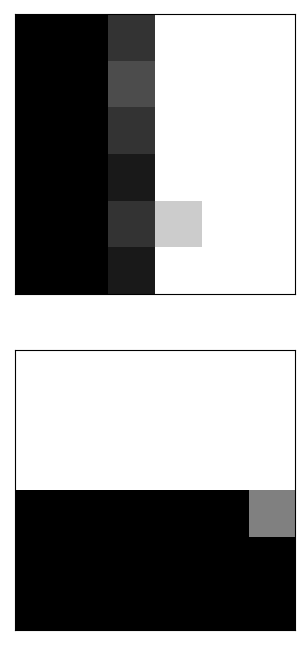

In [27]:
mante.psychometric_matrices(net_behav, coherences=coherences)

## Some plots

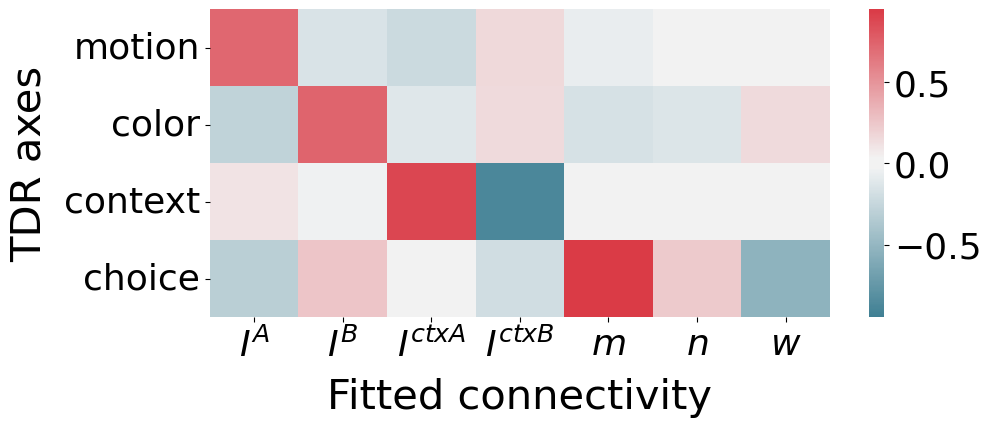

In [28]:
# Comparison between connectivity axes and TDR axes
vecs = [wi1, wi2, wi_ctx1, wi_ctx2, m, n, wo]
betas = [beta_motion, beta_color, beta_context, beta_choice]

mat = helpers.overlap_matrix2(betas, vecs, norm='norm', figsize=(10, 4))
plt.xlabel('Fitted connectivity')
plt.ylabel('TDR axes')
plt.xticks(np.arange(0.5, 7, 1), ['$I^A$', '$I^B$', '$I^{ctxA}$', '$I^{ctxB}$', '$m$', '$n$', '$w$'])
plt.yticks(np.arange(0.5, 4, 1), ['motion', 'color', 'context', 'choice'], rotation='horizontal')
plt.savefig('../figures/neurips/si_monkeyA_tdroverlaps.pdf', bbox_inches='tight')

In [29]:
r2s = np.array(stats.r2_idneurons(X_cent, traj, return_all=True))

In [30]:
idx_bad = np.where(r2s < 0)[0]
print(idx_bad)
print(len(idx_bad))

[  1  41  79 144 154 217 245 292 318 358 385 393 405 427 533 538 539 551
 707 708]
20


## Single neurons

In [31]:
conditions_sample = [((direction == 0) & (color == 5) & (context == 1)),
                     ((direction == 5) & (color == 0) & (context == 1)),
                     ((direction == 5) & (color == 0) & (context == -1)),
                     ((direction == 0) & (color == 5) & (context == -1))]
cmap1 = matplotlib.cm.get_cmap('bwr')
cmap2 = matplotlib.cm.get_cmap('PiYG')
colors = ['royalblue', 'seagreen', 'firebrick', 'darkorange']

-74.36615034125846


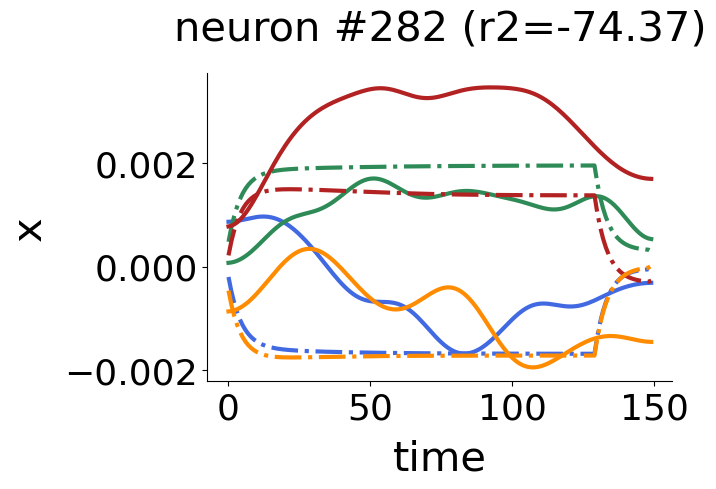

-30.7224358642855


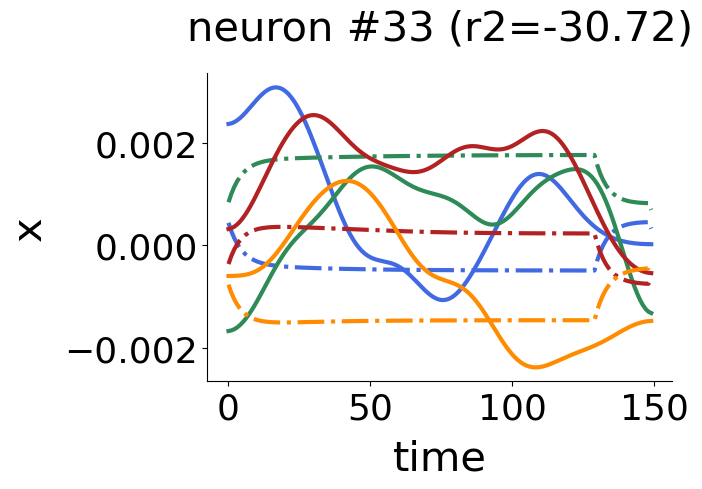

-12.383255321251335


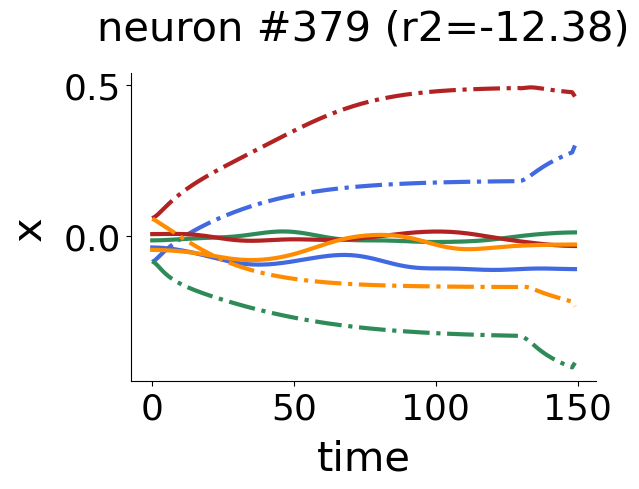

-3.011195028098661


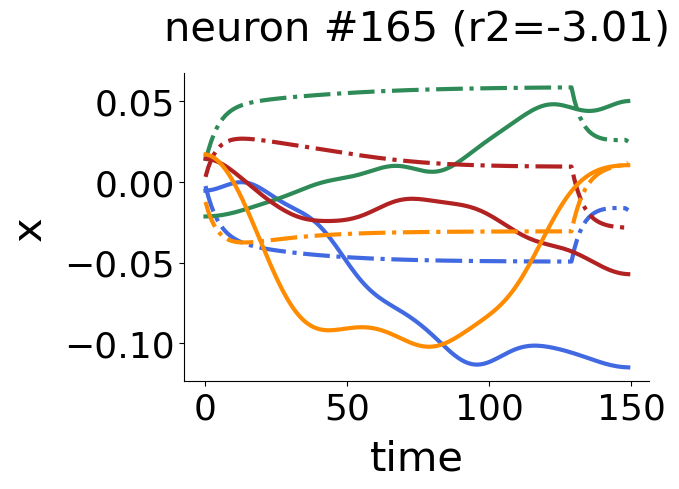

-2.284510327680968


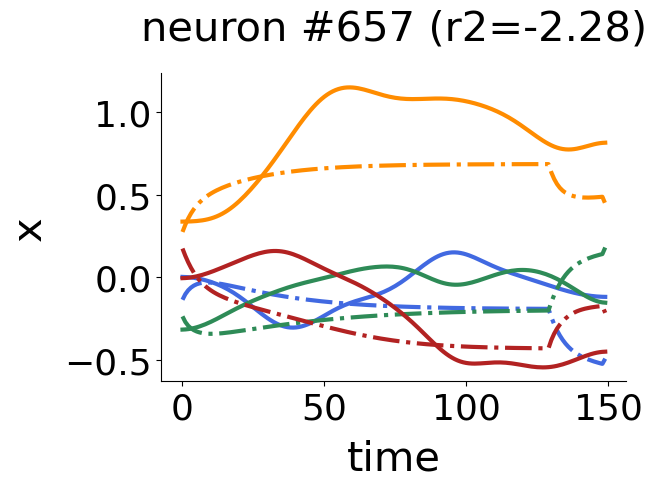

-1.6712862038743364


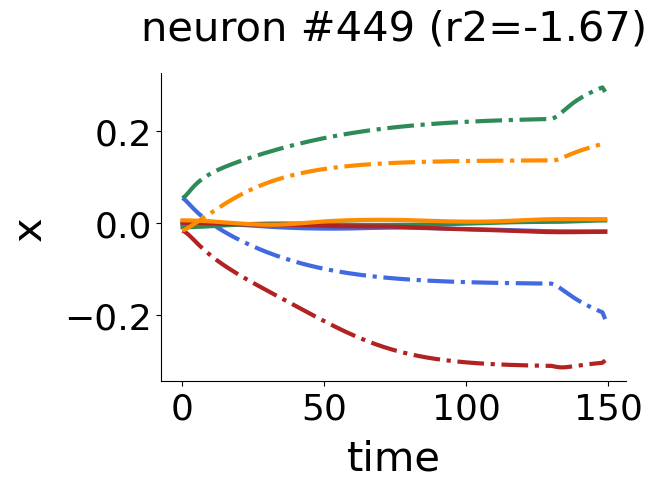

-1.645971001887581


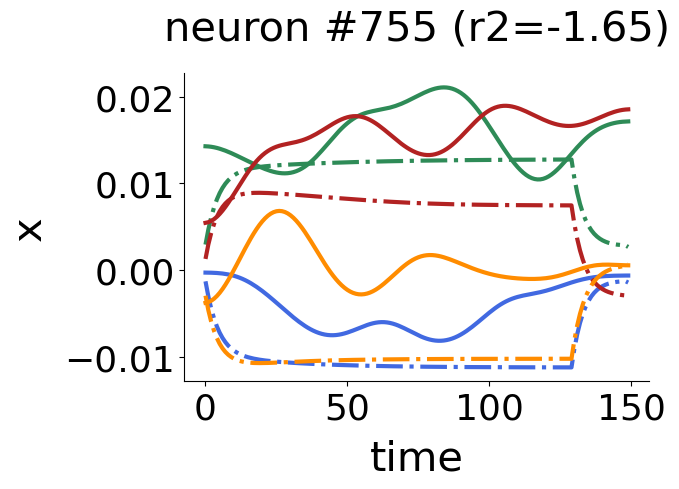

-1.567623041827706


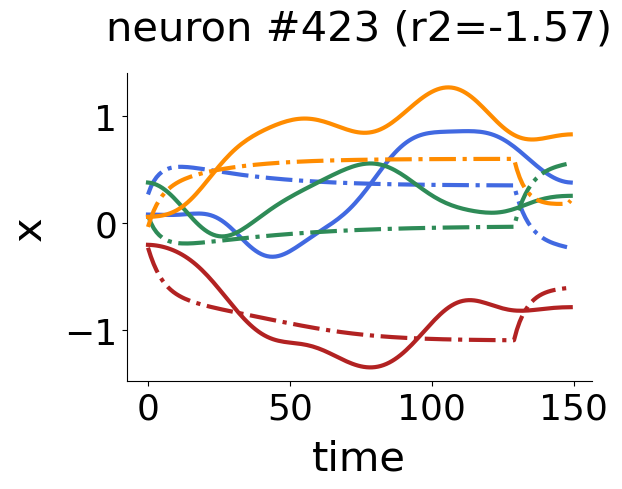

-1.0417799927352775


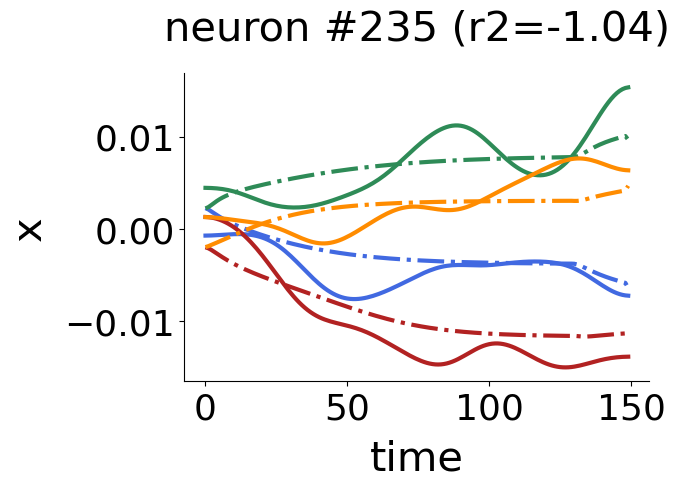

-0.8707081517372761


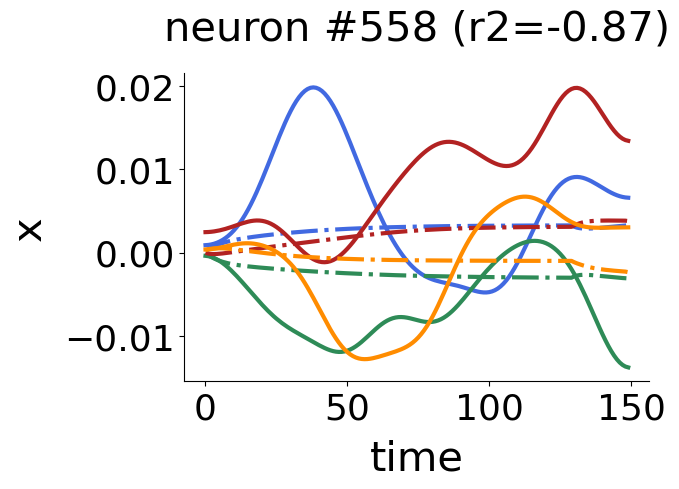

-0.7918565399150224


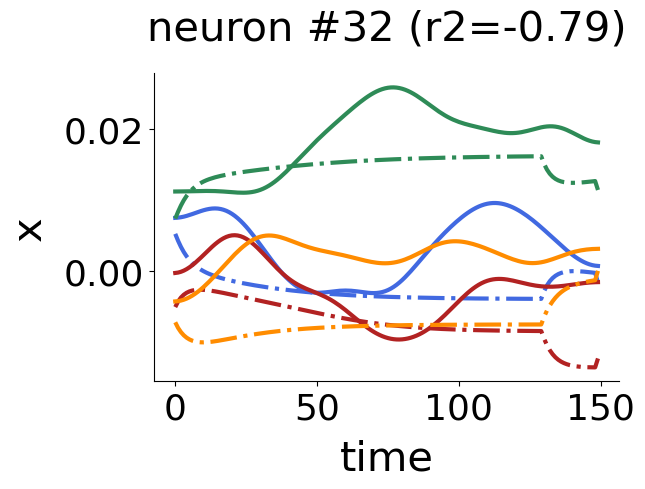

-0.7753256643327457


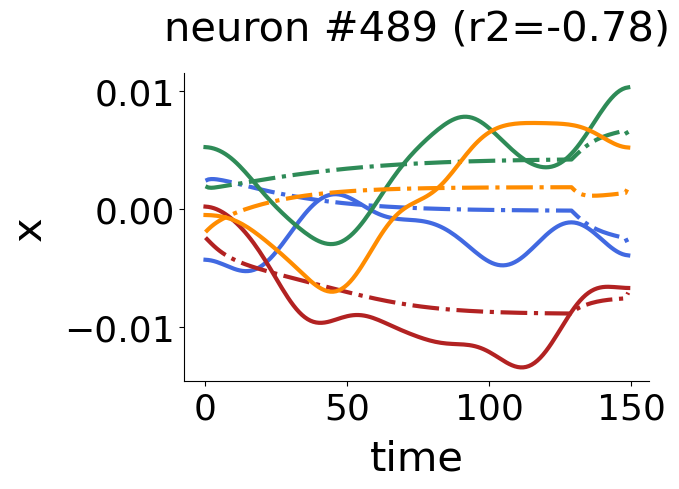

-0.7547818026889861


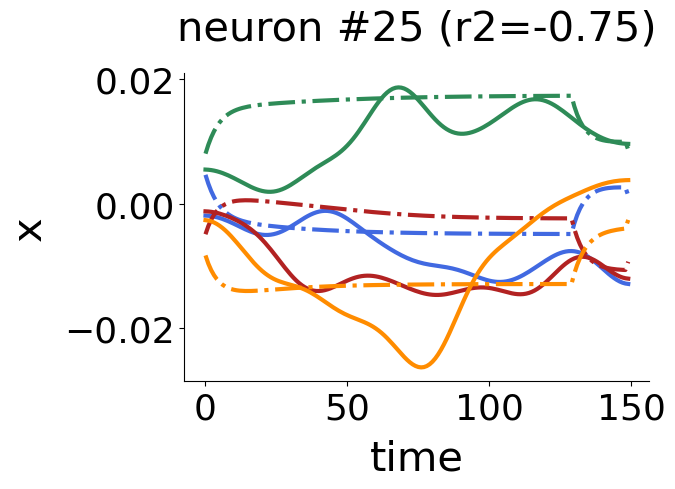

-0.7184799119998926


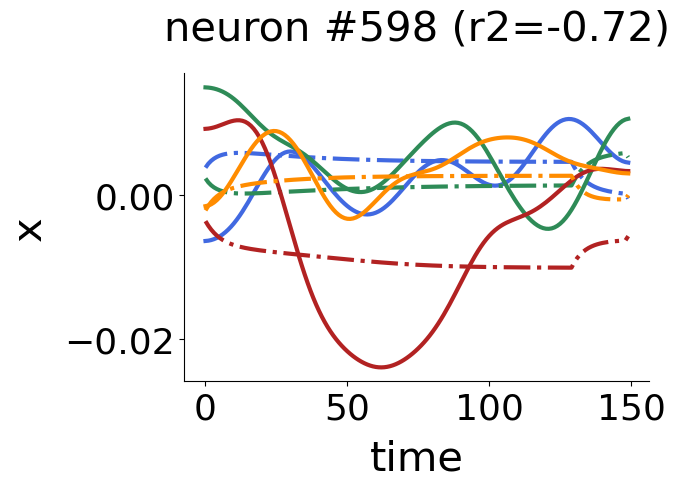

-0.6349759863312527


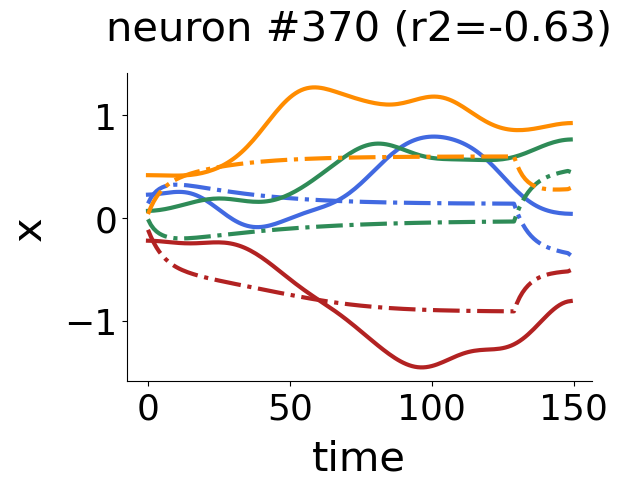

-0.3907977142917476


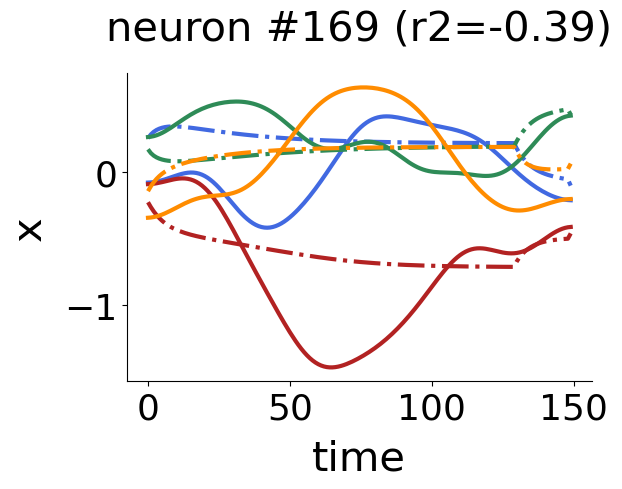

-0.32103440218123835


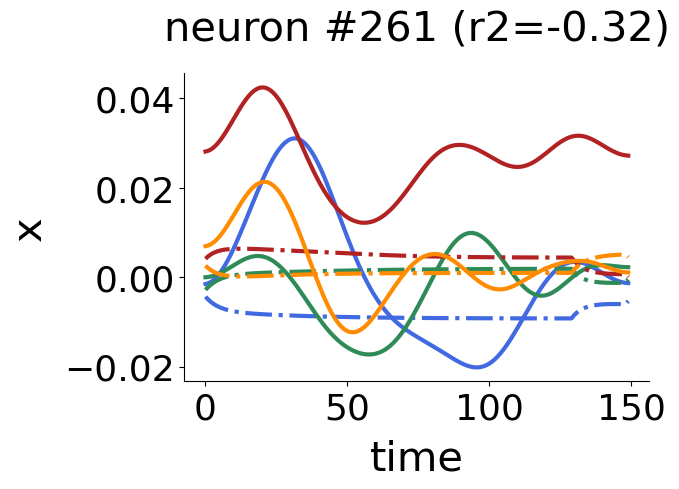

-0.27151178429081857


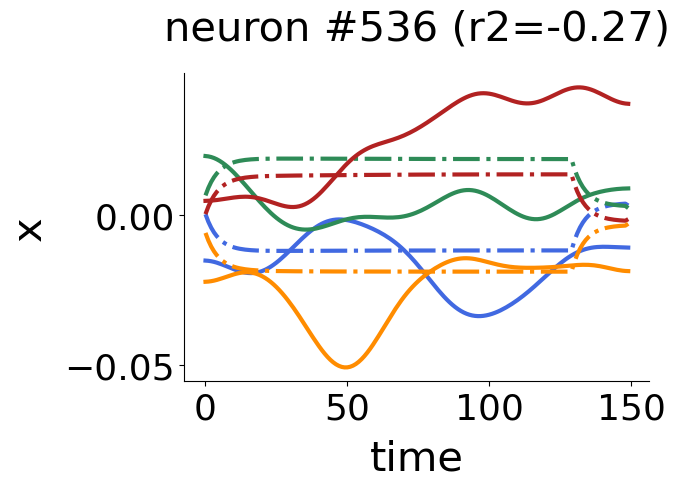

In [32]:
# conditions_rsample = random.sample(range(nconds), 4)
for i in np.argsort(r2s_all)[:18]:
    print(r2s_all[i])
    for c, k in enumerate(conditions_sample):
        pl, = plt.plot(X_cent[k, :, i].mean(axis=0), c=colors[c], lw=3)
        plt.plot(traj[k, :, i].mean(axis=0), ls='-.', c=pl.get_color(), lw=3)
    plt.title(f'neuron #{neurons_map_orig[i]} (r2={r2s_all[i]:.2f})')
    plt.xlabel('time')
    plt.ylabel('x')
    plt.savefig(f'../figures/neurips/si_monkeyA_neuron{neurons_map_orig[i]}.pdf', bbox_inches='tight')
    plt.show()
    

0.942862778911438


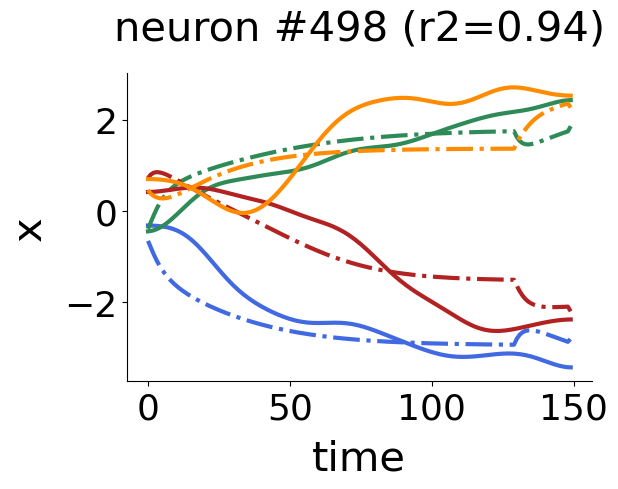

0.9377263286317692


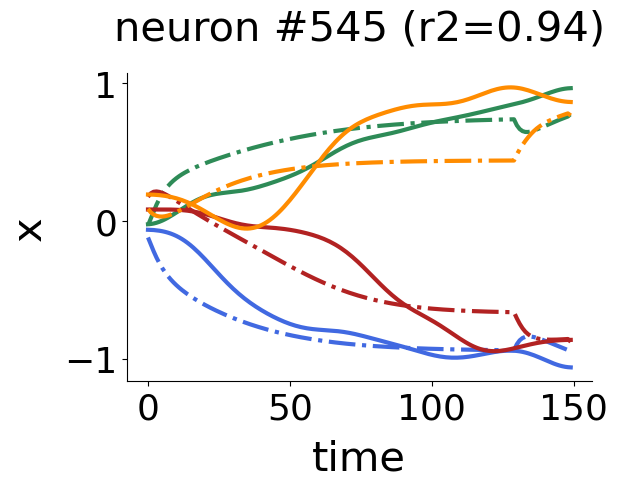

0.9331523813760466


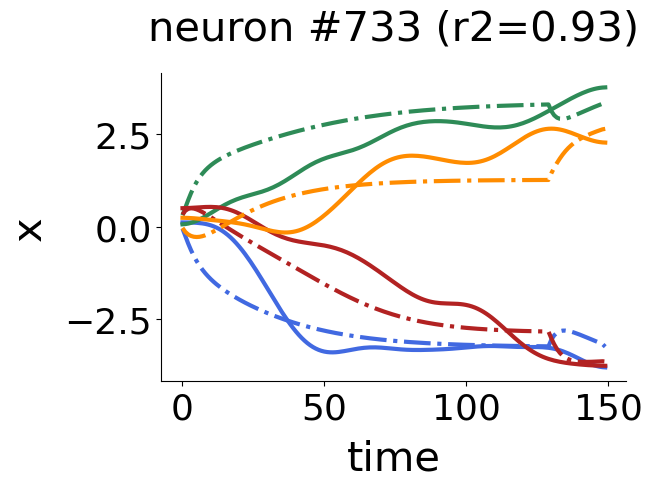

0.9310183436731074


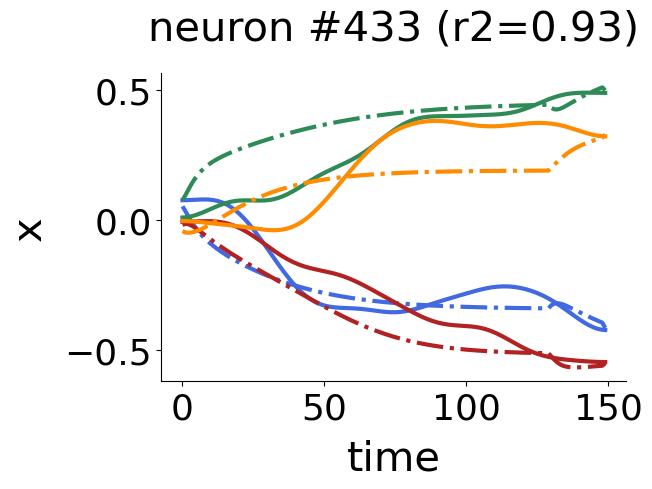

0.9303288868818859


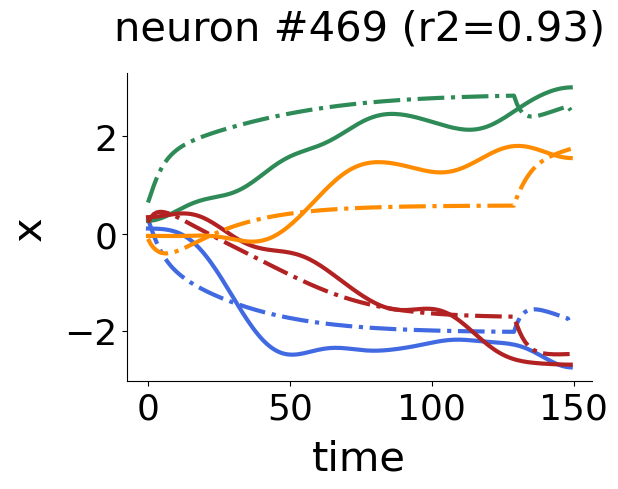

0.9286839584643423


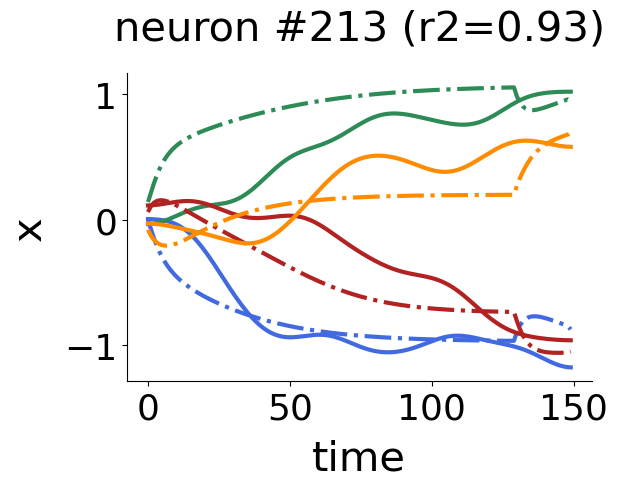

0.923628239597149


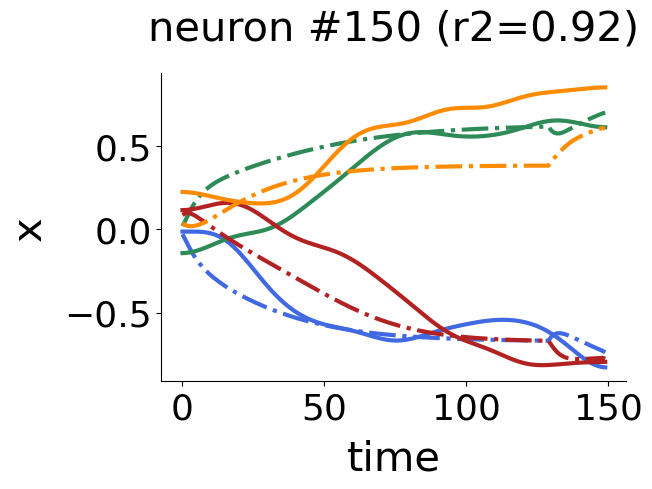

0.9193387409260789


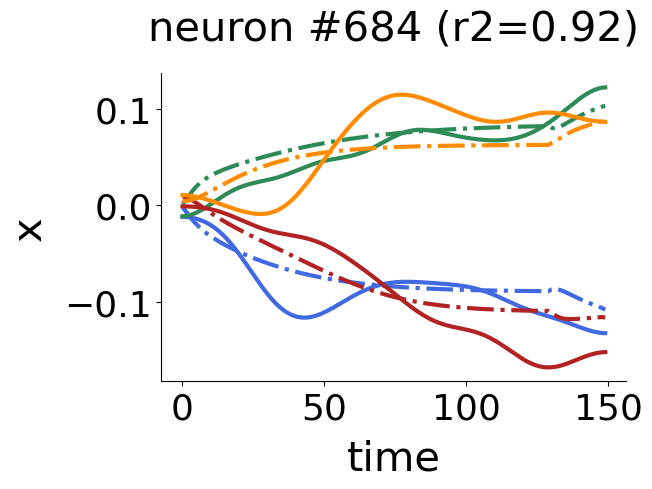

0.9178529001600522


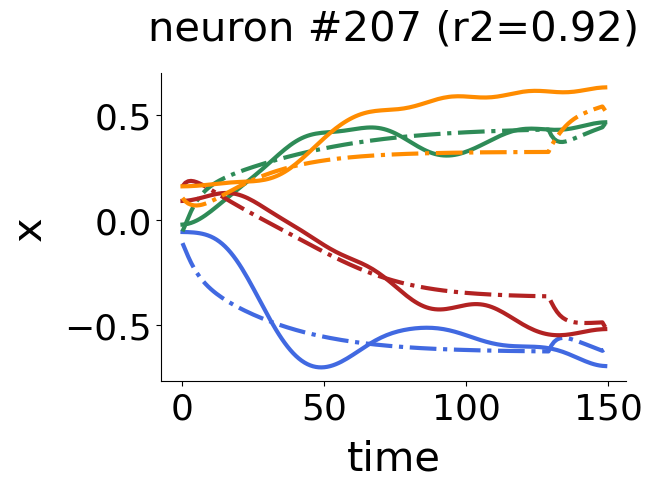

0.9163706675036878


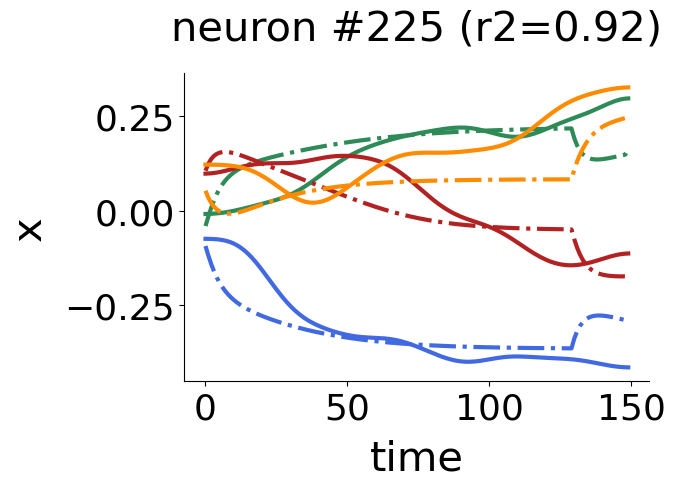

In [33]:
for i in np.argsort(r2s_all)[::-1][:10]:
    print(r2s_all[i])
    for c, k in enumerate(conditions_sample):
        pl, = plt.plot(X_cent[k, :, i].mean(axis=0), c=colors[c], lw=3)
        plt.plot(traj[k, :, i].mean(axis=0), ls='-.', c=pl.get_color(), lw=3)
    plt.title(f'neuron #{neurons_map_orig[i]} (r2={r2s_all[i]:.2f})')
    plt.xlabel('time')
    plt.ylabel('x')
    plt.savefig(f'../figures/neurips/si_monkeyA_neuron{neurons_map_orig[i]}.pdf', bbox_inches='tight')
    plt.show()

0.766872717740922


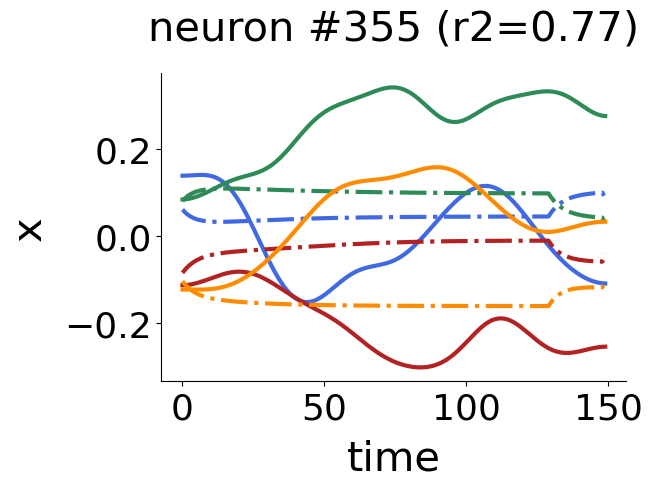

0.6288754863182596


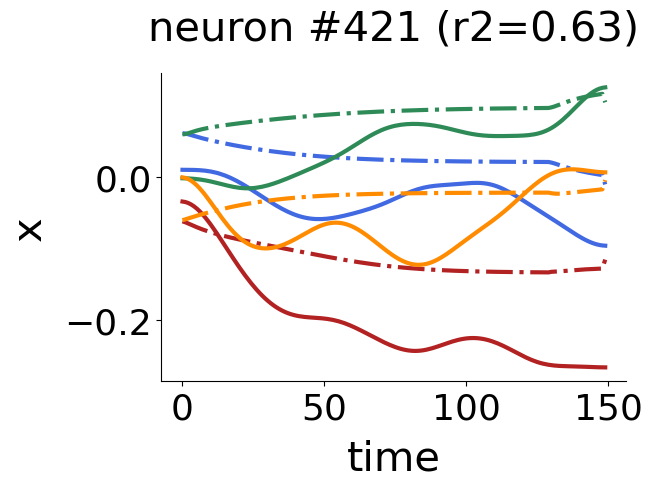

-0.021629632139293253


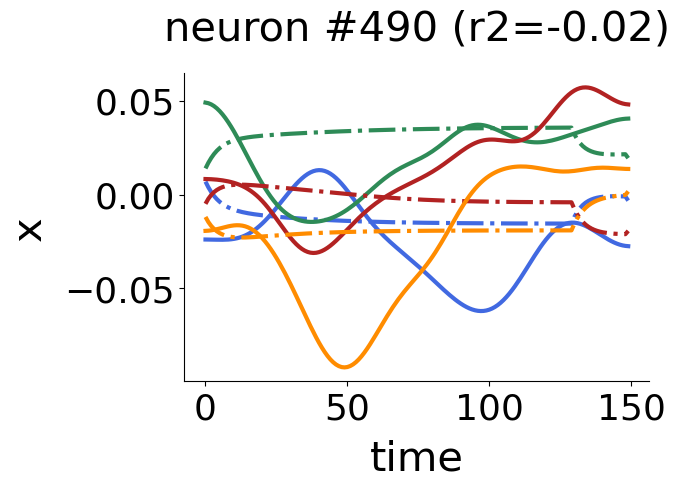

0.41104863972253747


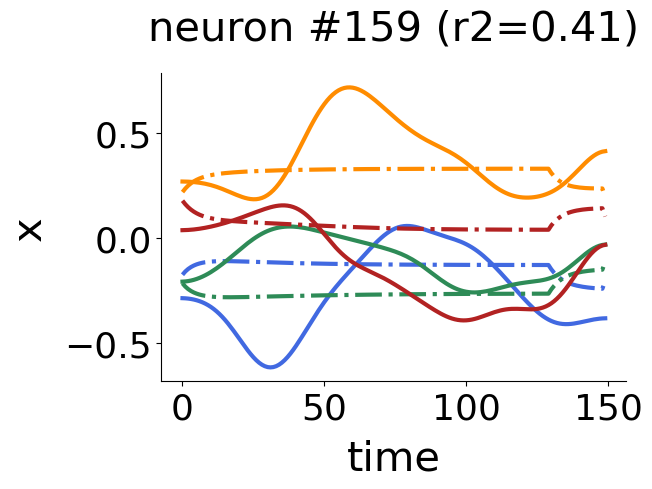

In [34]:
rdm_neurons = np.random.choice(np.arange(size), 4, replace=False)
for i in rdm_neurons:
    print(r2s_all[i])
    for c, k in enumerate(conditions_sample):
        pl, = plt.plot(X_cent[k, :, i].mean(axis=0), c=colors[c], lw=3)
        plt.plot(traj[k, :, i].mean(axis=0), ls='-.', c=pl.get_color(), lw=3)
    plt.title(f'neuron #{neurons_map_orig[i]} (r2={r2s_all[i]:.2f})')
    plt.xlabel('time')
    plt.ylabel('x')
    plt.savefig(f'../figures/neurips/si_monkeyA_neuron{neurons_map_orig[i]}.pdf', bbox_inches='tight')
    plt.show()

## R2s

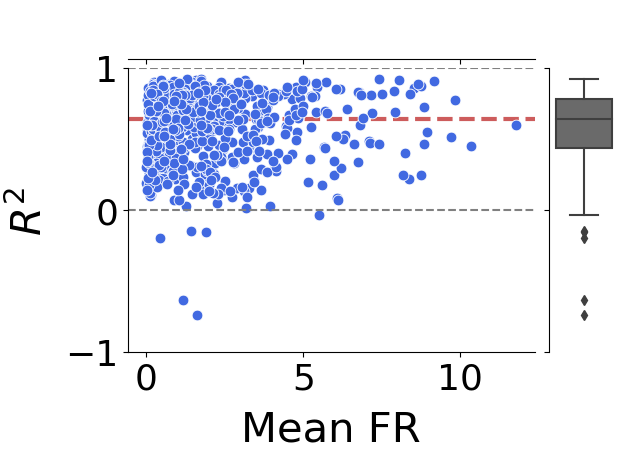

In [35]:
g = sns.JointGrid()
g.fig.set_figwidth(6)
g.fig.set_figheight(4)
sns.scatterplot(x=X_mean, y=r2s, s=60, ax=g.ax_joint, color='royalblue')
sns.boxplot(y=r2s, ax=g.ax_marg_y, saturation=0)
# sns.kdeplot(x=X_mean, ax=g.ax_marg_x)
g.ax_joint.set_xlabel('Mean FR')
g.ax_joint.set_ylabel('$R^2$')
g.ax_joint.axhline(0, c='gray', ls='--')
g.ax_joint.axhline(1, c='gray', ls='--')
g.ax_joint.axhline(np.median(r2s), c='indianred', ls='--', lw=3, zorder=0)
plt.ylim(-1, 1)
plt.savefig('../figures/neurips/r2_fr.pdf', bbox_inches='tight')

/Users/avalente/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


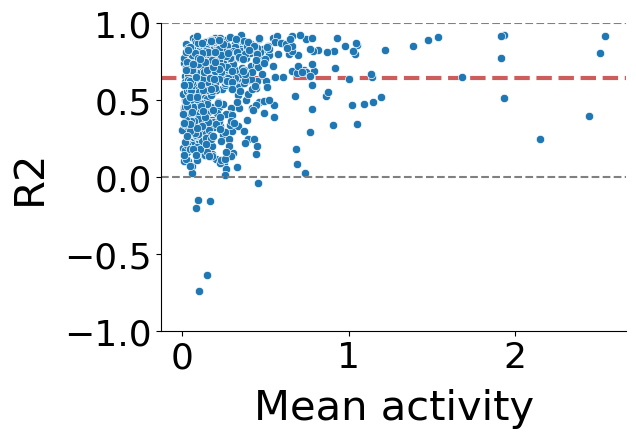

In [36]:
# And with the mean deviation to baseline activity
sns.scatterplot(mean_abs_act[r2s> -1], r2s[r2s > -1])
plt.ylim(-1, 1)
plt.axhline(0, c='gray', ls='--')
plt.axhline(1, c='gray', ls='--')
plt.xlabel('Mean activity')
plt.ylabel('R2')
# plt.scatter(-0.1, np.median(r2s), c='indianred', marker='>', s=100)
plt.axhline(np.median(r2s), c='indianred', ls='--', lw=3, zorder=0)

In [37]:
# Removing the neurons with r2 < 0
net_tmp = net_behav.clone()

with torch.no_grad():
    net_tmp.wi[:, idx_bad] = 0
    net_tmp.m[idx_bad] = 0
    net_tmp.n[idx_bad] = 0

loss, acc = mante.test_mante(net_tmp, inputs, targets_task, mask_task)
print(acc)
train(net_tmp, inputs, targets_task, mask_task, 20, lr=1e-1, keep_best=True)
loss, acc = mante.test_mante(net_tmp, inputs, targets_task, mask_task)
print(acc)

0.8194444179534912
Training...
initial loss: 0.620
epoch 0:  loss=0.573  (took 0.28 s) *
epoch 1:  loss=0.642  (took 0.30 s)
epoch 2:  loss=0.549  (took 0.28 s) *
epoch 3:  loss=0.576  (took 0.29 s)
epoch 4:  loss=0.634  (took 0.32 s)
epoch 5:  loss=0.579  (took 0.29 s)
epoch 6:  loss=0.542  (took 0.48 s) *
epoch 7:  loss=0.644  (took 0.38 s)
epoch 8:  loss=0.556  (took 0.34 s)
epoch 9:  loss=0.511  (took 0.42 s) *
epoch 10:  loss=0.494  (took 0.33 s) *
epoch 11:  loss=0.427  (took 0.34 s) *
epoch 12:  loss=0.428  (took 0.30 s)
epoch 13:  loss=0.458  (took 0.31 s)
epoch 14:  loss=0.471  (took 0.30 s)
epoch 15:  loss=0.444  (took 0.31 s)
epoch 16:  loss=0.469  (took 0.30 s)
epoch 17:  loss=0.472  (took 0.30 s)
epoch 18:  loss=0.491  (took 0.32 s)
epoch 19:  loss=0.466  (took 0.30 s)
0.8472222089767456


In [38]:
# What if we remove other random sets of as many neurons ?
for _ in range(10):
    rndm_sample = np.random.choice(np.arange(size), len(idx_bad))
    net_tmp = net_behav.clone()
    with torch.no_grad():
        net_tmp.wi[:, rndm_sample] = 0
        net_tmp.m[rndm_sample] = 0
        net_tmp.n[rndm_sample] = 0
    loss, acc = mante.test_mante(net_tmp, inputs, targets_task, mask_task)
    print(acc)

0.9722222089767456
1.0
0.9861111044883728
1.0
1.0
0.9722222089767456
0.9722222089767456
0.625
0.9722222089767456
0.9722222089767456


In summary, the network is really not robust, and the "very poorly fitted" neurons are essential to task performance. So the recorded neurons by themselves could not do the task? To be checked with the full-rank net.

## Dim red

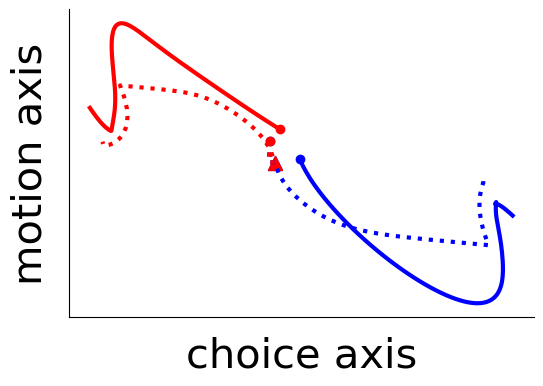

In [39]:
cmap = matplotlib.cm.get_cmap('bwr')

conditions = [((direction == 0) & (context == 1)),
              ((direction == 5) & (context == 1))]
colors = [cmap(0), cmap(256)]

ax1 = beta_choice
ax2 = beta_motion

for c in range(len(conditions)):
    plt.plot(X_cent[conditions[c]].mean(axis=0) @ ax1, 
             X_cent[conditions[c]].mean(axis=0) @ ax2, c=colors[c], lw=3)    
    plt.plot(X_cent[conditions[c]].mean(axis=0)[0] @ ax1, 
             X_cent[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0) @ ax1, 
             traj_tot[conditions[c]].mean(axis=0) @ ax2, 
             c=colors[c], ls='dotted', lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0)[0] @ ax1, 
             traj_tot[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], ls='dotted', lw=3)
    plt.scatter(traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax1,
                traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax2,
                color=colors[c], marker='^', s=100)
plt.xlabel('choice axis')
plt.ylabel('motion axis')
plt.xticks([])
plt.yticks([])
plt.savefig('../figures/neurips/proj_si1.pdf', bbox_inches='tight')

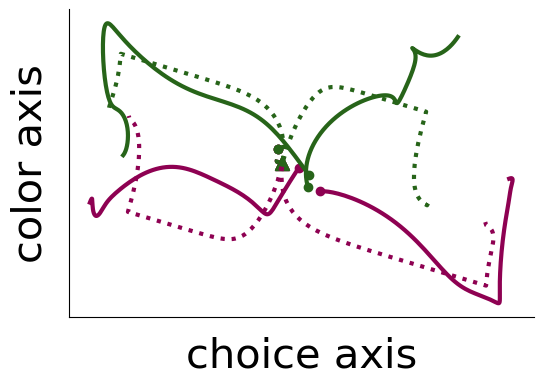

In [40]:
cmap = matplotlib.cm.get_cmap('PiYG')

conditions = [((color == i) & (context == 1) & (choice == j)) for i in (0, 5) for j in (-1, 1)]
colors = [cmap(0)] * 2 + [cmap(256)] * 2

ax1 = beta_choice
ax2 = beta_color

for c in range(len(conditions)):
    plt.plot(X_cent[conditions[c]].mean(axis=0) @ ax1, 
             X_cent[conditions[c]].mean(axis=0) @ ax2, c=colors[c], lw=3)    
    plt.plot(X_cent[conditions[c]].mean(axis=0)[0] @ ax1, 
             X_cent[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0) @ ax1, 
             traj_tot[conditions[c]].mean(axis=0) @ ax2, 
             c=colors[c], ls='dotted', lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0)[0] @ ax1, 
             traj_tot[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], ls='dotted', lw=3)
    plt.scatter(traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax1,
                traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax2,
                color=colors[c], marker='^', s=100)
plt.xlabel('choice axis')
plt.ylabel('color axis')
plt.xticks([])
plt.yticks([])
plt.savefig('../figures/neurips/proj_si2.pdf', bbox_inches='tight')

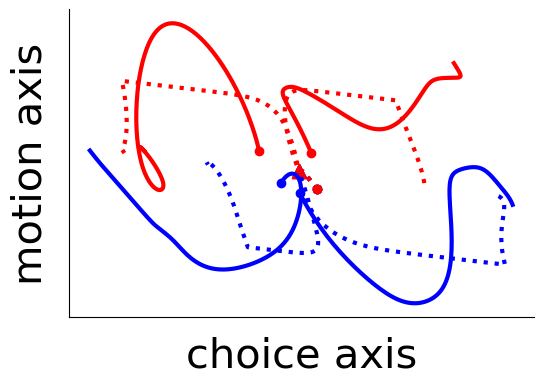

In [41]:
cmap = matplotlib.cm.get_cmap('bwr')

conditions = [((direction == i) & (context == -1) & (choice == j)) for i in (0, 5) for j in (-1, 1)]
colors = [cmap(0)] * 2 + [cmap(256)] * 2

ax1 = beta_choice
ax2 = beta_motion

for c in range(len(conditions)):
    plt.plot(X_cent[conditions[c]].mean(axis=0) @ ax1,
             X_cent[conditions[c]].mean(axis=0) @ ax2, c=colors[c], lw=3)    
    plt.plot(X_cent[conditions[c]].mean(axis=0)[0] @ ax1, 
             X_cent[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0) @ ax1, 
             traj_tot[conditions[c]].mean(axis=0) @ ax2, 
             c=colors[c], ls='dotted', lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0)[0] @ ax1, 
             traj_tot[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], ls='dotted', lw=3)
    plt.scatter(traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax1,
                traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax2,
                color=colors[c], marker='^', s=100)
plt.xlabel('choice axis')
plt.ylabel('motion axis')
plt.xticks([])
plt.yticks([])
plt.savefig('../figures/neurips/proj_si3.pdf', bbox_inches='tight')

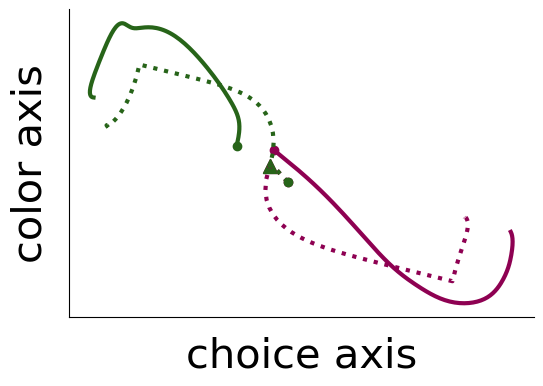

In [42]:
cmap = matplotlib.cm.get_cmap('PiYG')

conditions = [((color == i) & (context == -1)) for i in (0, 5)]
colors = [cmap(0), cmap(256)]

ax1 = beta_choice
ax2 = beta_color

for c in range(len(conditions)):
    plt.plot(X_cent[conditions[c]].mean(axis=0) @ ax1,
             X_cent[conditions[c]].mean(axis=0) @ ax2, c=colors[c], lw=3)    
    plt.plot(X_cent[conditions[c]].mean(axis=0)[0] @ ax1, 
             X_cent[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0) @ ax1, 
             traj_tot[conditions[c]].mean(axis=0) @ ax2, 
             c=colors[c], ls='dotted', lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0)[0] @ ax1, 
             traj_tot[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], ls='dotted', lw=3)
    plt.scatter(traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax1,
                traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax2,
                color=colors[c], marker='^', s=100)
plt.xlabel('choice axis')
plt.ylabel('color axis')
plt.xticks([])
plt.yticks([])
plt.savefig('../figures/neurips/proj_si4.pdf', bbox_inches='tight')

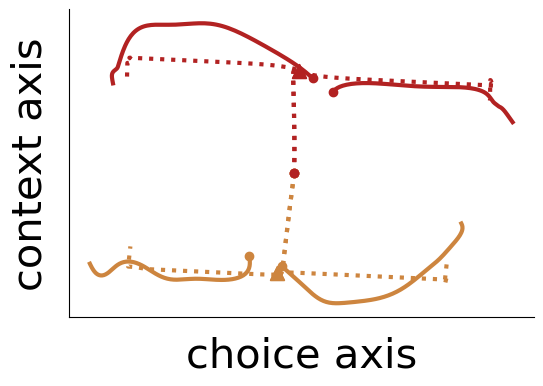

In [43]:
cmap = matplotlib.cm.get_cmap('PiYG')

conditions = [((choice == i) & (context == j)) for i in (-1, 1) for j in (-1, 1)]
colors = ['peru', 'firebrick', 'peru', 'firebrick']

ax1 = beta_choice
ax2 = beta_context

for c in range(len(conditions)):
    plt.plot(X_cent[conditions[c]].mean(axis=0) @ ax1,
             X_cent[conditions[c]].mean(axis=0) @ ax2, c=colors[c], lw=3)    
    plt.plot(X_cent[conditions[c]].mean(axis=0)[0] @ ax1, 
             X_cent[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0) @ ax1, 
             traj_tot[conditions[c]].mean(axis=0) @ ax2, 
             c=colors[c], ls='dotted', lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0)[0] @ ax1, 
             traj_tot[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], ls='dotted', lw=3)
    plt.scatter(traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax1,
                traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax2,
                color=colors[c], marker='^', s=100)
plt.xlabel('choice axis')
plt.ylabel('context axis')
plt.xticks([])
plt.yticks([])
plt.savefig('../figures/neurips/proj_si5.pdf', bbox_inches='tight')

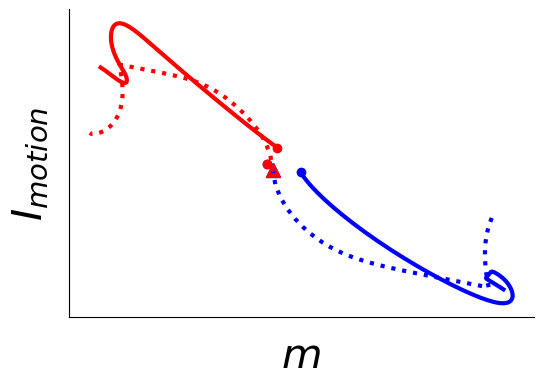

In [44]:
cmap = matplotlib.cm.get_cmap('bwr')

conditions = [((direction == 0) & (context == 1)),
              ((direction == 5) & (context == 1))]
colors = [cmap(0), cmap(256)]

ax1 = m
ax2 = wis[0]

for c in range(len(conditions)):
    plt.plot(X_cent[conditions[c]].mean(axis=0) @ ax1, 
             X_cent[conditions[c]].mean(axis=0) @ ax2, c=colors[c], lw=3)    
    plt.plot(X_cent[conditions[c]].mean(axis=0)[0] @ ax1, 
             X_cent[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0) @ ax1, 
             traj_tot[conditions[c]].mean(axis=0) @ ax2, 
             c=colors[c], ls='dotted', lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0)[0] @ ax1, 
             traj_tot[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], ls='dotted', lw=3)
    plt.scatter(traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax1,
                traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax2,
                color=colors[c], marker='^', s=100)
plt.xlabel('$m$')
plt.ylabel('$I_{motion}$')
plt.xticks([])
plt.yticks([])
plt.savefig('../figures/neurips/proj1.pdf', bbox_inches='tight')

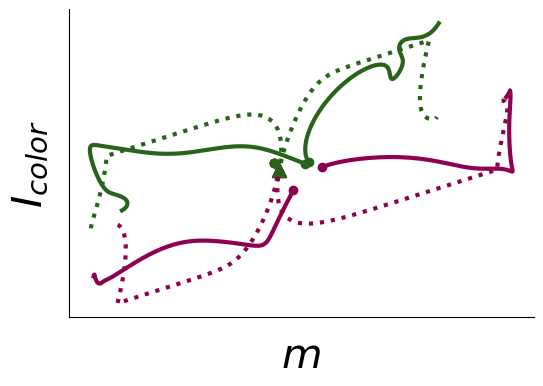

In [45]:
cmap = matplotlib.cm.get_cmap('PiYG')

conditions = [((color == i) & (context == 1) & (choice == j)) for i in (0, 5) for j in (-1, 1)]
colors = [cmap(0)] * 2 + [cmap(256)] * 2

ax1 = m
ax2 = wis[1]

for c in range(len(conditions)):
    plt.plot(X_cent[conditions[c]].mean(axis=0) @ ax1, 
             X_cent[conditions[c]].mean(axis=0) @ ax2, c=colors[c], lw=3)    
    plt.plot(X_cent[conditions[c]].mean(axis=0)[0] @ ax1, 
             X_cent[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0) @ ax1, 
             traj_tot[conditions[c]].mean(axis=0) @ ax2, 
             c=colors[c], ls='dotted', lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0)[0] @ ax1, 
             traj_tot[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], ls='dotted', lw=3)
    plt.scatter(traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax1,
                traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax2,
                color=colors[c], marker='^', s=100)
plt.xlabel('$m$')
plt.ylabel('$I_{color}$')
plt.xticks([])
plt.yticks([])
plt.savefig('../figures/neurips/proj2.pdf', bbox_inches='tight')

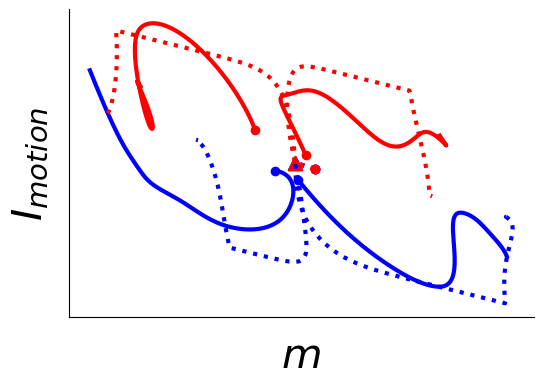

In [46]:
cmap = matplotlib.cm.get_cmap('bwr')

conditions = [((direction == i) & (context == -1) & (choice == j)) for i in (0, 5) for j in (-1, 1)]
colors = [cmap(0)] * 2 + [cmap(256)] * 2

ax1 = m
ax2 = wis[0]

for c in range(len(conditions)):
    plt.plot(X_cent[conditions[c]].mean(axis=0) @ ax1,
             X_cent[conditions[c]].mean(axis=0) @ ax2, c=colors[c], lw=3)    
    plt.plot(X_cent[conditions[c]].mean(axis=0)[0] @ ax1, 
             X_cent[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0) @ ax1, 
             traj_tot[conditions[c]].mean(axis=0) @ ax2, 
             c=colors[c], ls='dotted', lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0)[0] @ ax1, 
             traj_tot[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], ls='dotted', lw=3)
    plt.scatter(traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax1,
                traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax2,
                color=colors[c], marker='^', s=100)
plt.xlabel('$m$')
plt.ylabel('$I_{motion}$')
plt.xticks([])
plt.yticks([])
plt.savefig('../figures/neurips/proj3.pdf', bbox_inches='tight')

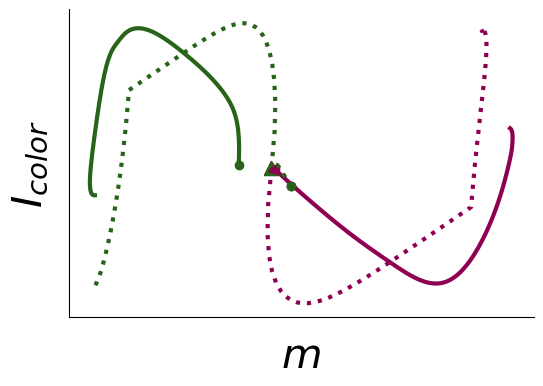

In [47]:
cmap = matplotlib.cm.get_cmap('PiYG')

conditions = [((color == i) & (context == -1)) for i in (0, 5)]
colors = [cmap(0), cmap(256)]

ax1 = m
ax2 = wis[1]

for c in range(len(conditions)):
    plt.plot(X_cent[conditions[c]].mean(axis=0) @ ax1,
             X_cent[conditions[c]].mean(axis=0) @ ax2, c=colors[c], lw=3)    
    plt.plot(X_cent[conditions[c]].mean(axis=0)[0] @ ax1, 
             X_cent[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0) @ ax1, 
             traj_tot[conditions[c]].mean(axis=0) @ ax2, 
             c=colors[c], ls='dotted', lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0)[0] @ ax1, 
             traj_tot[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], ls='dotted', lw=3)
    plt.scatter(traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax1,
                traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax2,
                color=colors[c], marker='^', s=100)
plt.xlabel('$m$')
plt.ylabel('$I_{color}$')
plt.xticks([])
plt.yticks([])
plt.savefig('../figures/neurips/proj4.pdf', bbox_inches='tight')

([], [])

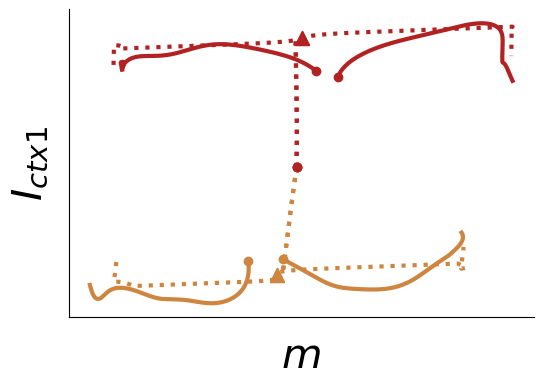

In [48]:
cmap = matplotlib.cm.get_cmap('PiYG')

conditions = [((choice == i) & (context == j)) for i in (-1, 1) for j in (-1, 1)]
colors = ['peru', 'firebrick', 'peru', 'firebrick']

ax1 = m
ax2 = wis[2]

for c in range(len(conditions)):
    plt.plot(X_cent[conditions[c]].mean(axis=0) @ ax1,
             X_cent[conditions[c]].mean(axis=0) @ ax2, c=colors[c], lw=3)    
    plt.plot(X_cent[conditions[c]].mean(axis=0)[0] @ ax1, 
             X_cent[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0) @ ax1, 
             traj_tot[conditions[c]].mean(axis=0) @ ax2, 
             c=colors[c], ls='dotted', lw=3)
    plt.plot(traj_tot[conditions[c]].mean(axis=0)[0] @ ax1, 
             traj_tot[conditions[c]].mean(axis=0)[0] @ ax2, 
             marker='o', c=colors[c], ls='dotted', lw=3)
    plt.scatter(traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax1,
                traj_tot[conditions[c]].mean(axis=0)[mante.ctx_only_pre_duration_discrete] @ ax2,
                color=colors[c], marker='^', s=100)
plt.xlabel('$m$')
plt.ylabel('$I_{ctx1}$')
plt.xticks([])
plt.yticks([])

# Gaussian mixtures

In [49]:
z, model = clustering.gmm_fit(wis+ms+ns, 2, algo='bayes', random_state=2022)

In [50]:
vecs = wis + ms + ns
i1, i2, ic1, ic2 = wis
n = ns[0]
m = ms[0]

## Visualizations

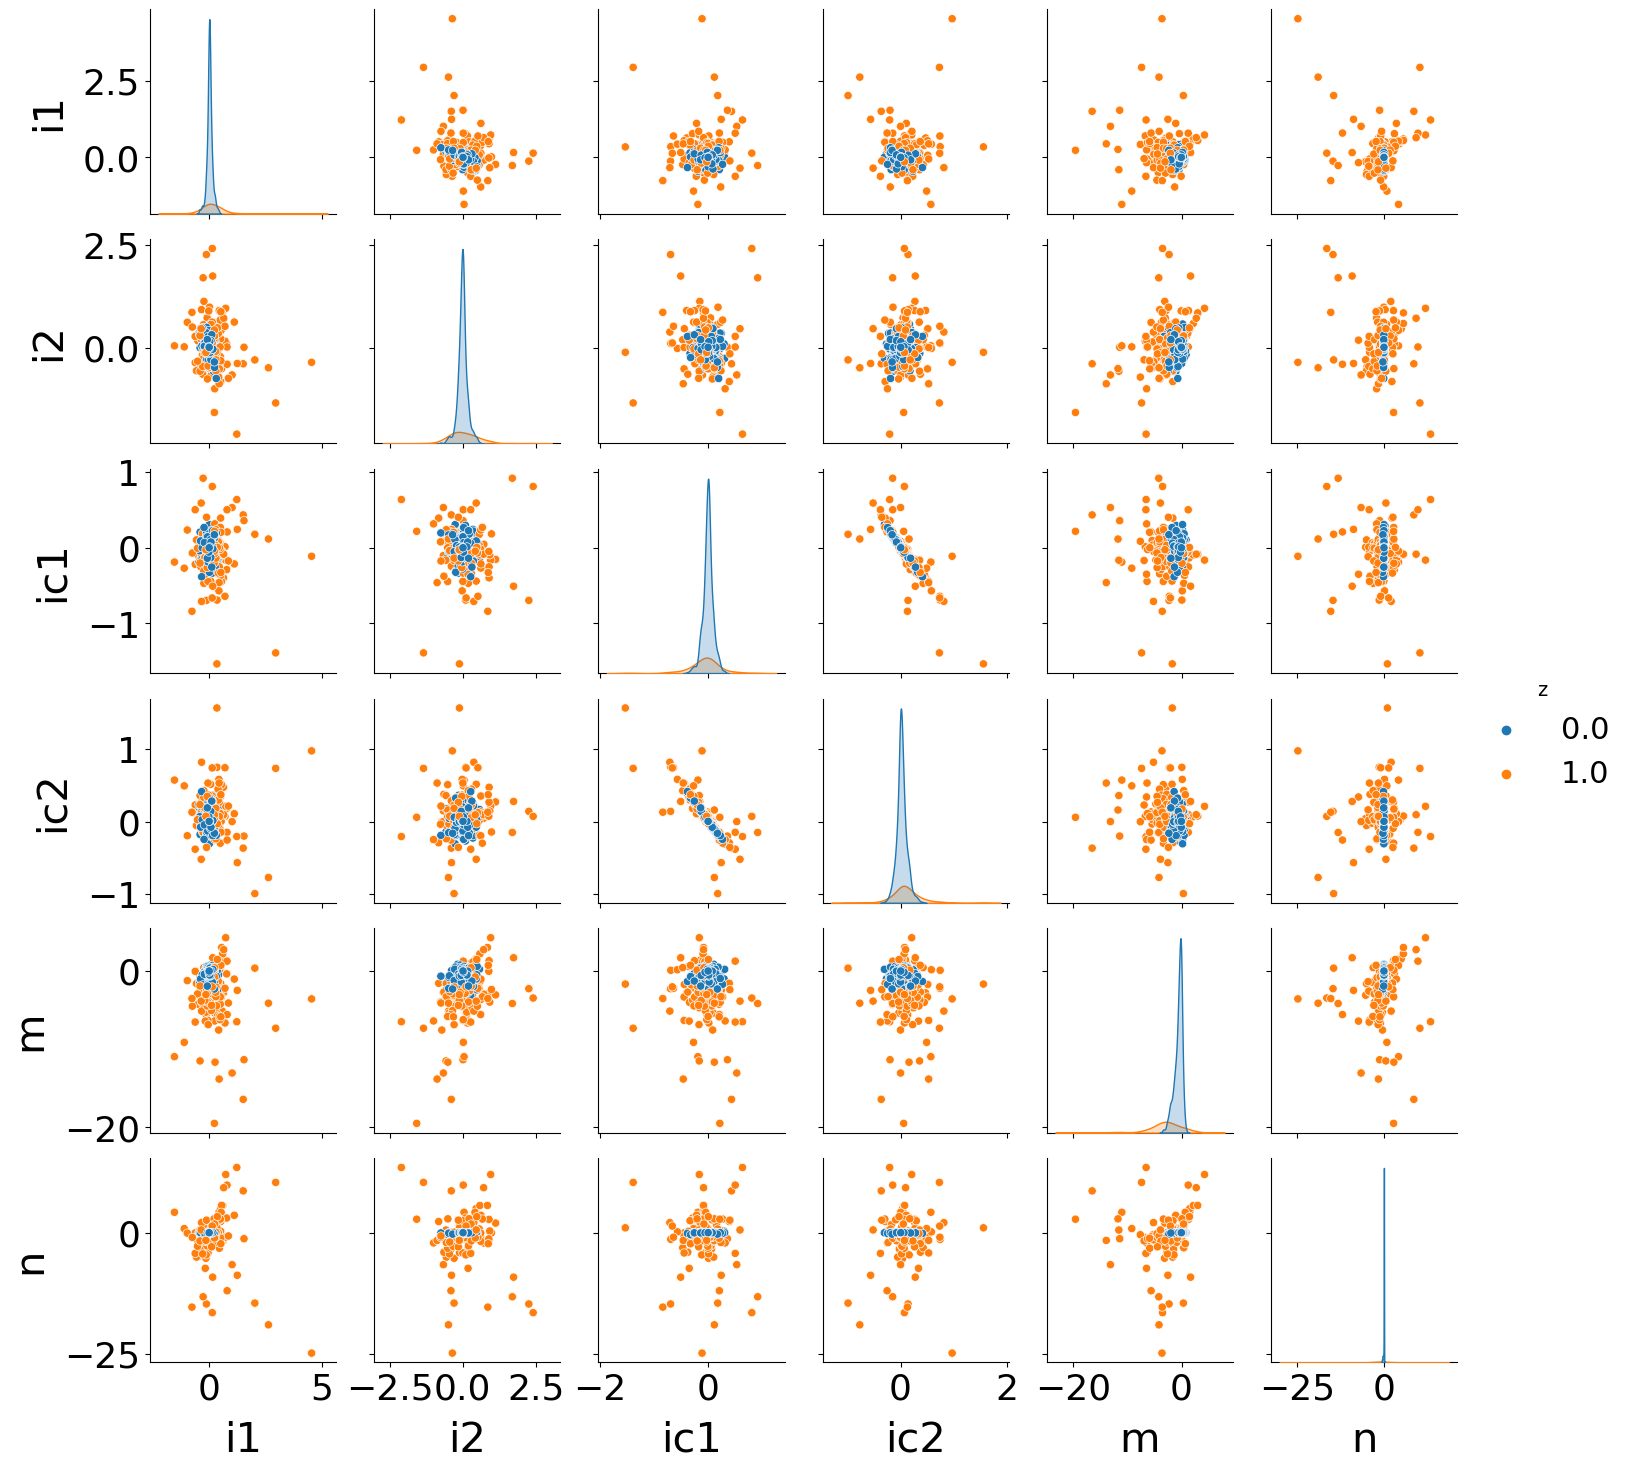

In [51]:
%matplotlib inline
data_plot = pd.DataFrame(np.stack(vecs + [z]).T, columns = ['i1', 'i2', 'ic1', 'ic2', 'm', 'n', 'z'])
sns.pairplot(data_plot, hue='z')
plt.savefig('../figures/neurips/distr_monkeyA.pdf', bbox_inches='tight')

In [52]:
kurtosis(np.array(vecs).T)

array([62.725487, 15.70929 , 18.904324, 16.84238 , 22.008568, 40.08307 ],
      dtype=float32)

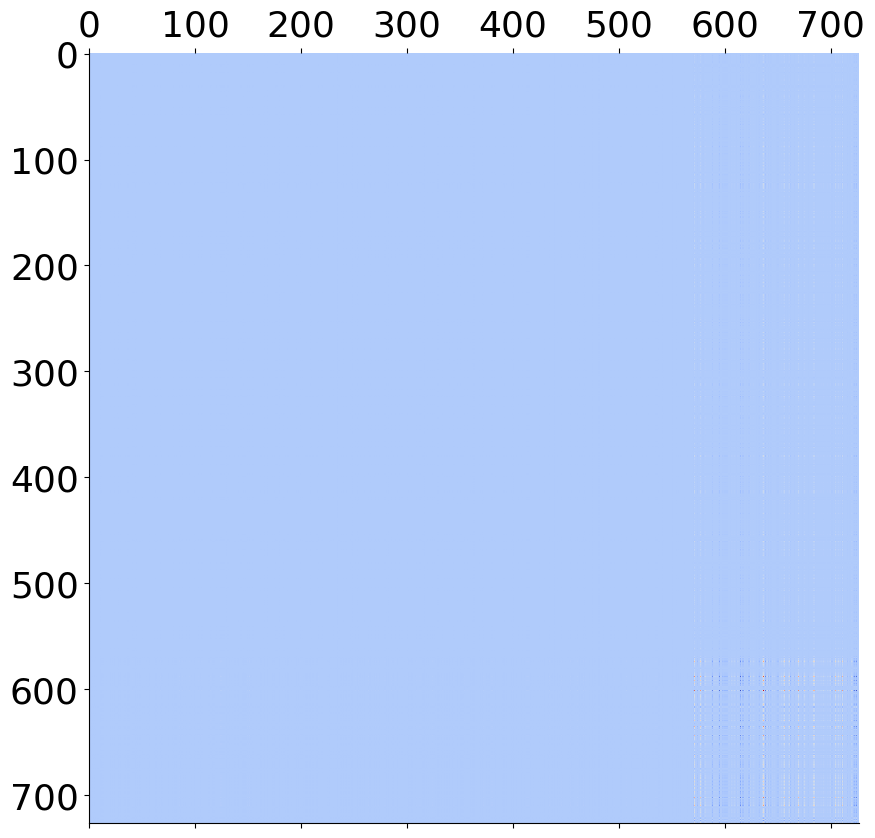

In [53]:
# Connectivity matrix
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
reorder = np.argsort(z)
ax.matshow(np.outer(m, n)[reorder][:, reorder], cmap='coolwarm')
#plt.colorbar(ax=ax)

[570 157]


<BarContainer object of 2 artists>

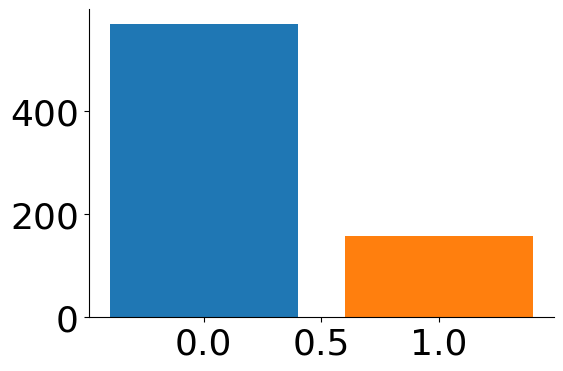

In [54]:
_, counts = np.unique(z, return_counts=True)
print(counts)
plt.bar([0, 1], counts, color=['tab:blue', 'tab:orange'])

/Users/avalente/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/avalente/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


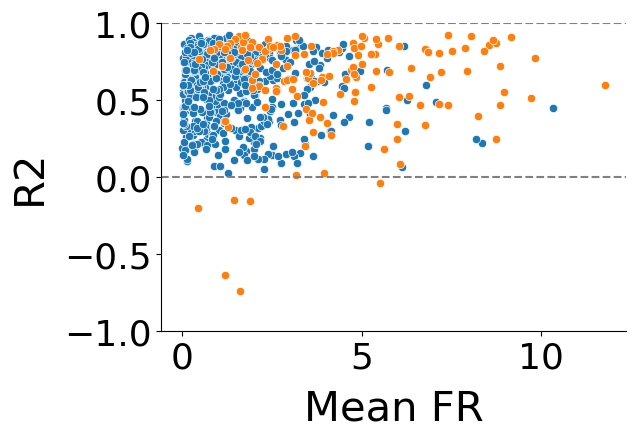

In [55]:
# Are poorly fitted neurons irrelevant ?
r2s = np.array(stats.r2_idneurons(X_cent, traj, return_all=True))
sns.scatterplot(X_mean[z==0], r2s[z==0], color='tab:blue')
sns.scatterplot(X_mean[z==1], r2s[z==1], color='tab:orange')
plt.ylim(-1, 1)
plt.axhline(0, c='gray', ls='--')
plt.axhline(1, c='gray', ls='--')
plt.xlabel('Mean FR')
plt.ylabel('R2')
plt.savefig('../figures/neurips/distr_r2mA.pdf', bbox_inches='tight')

## Inactivation

In [56]:
# Lets' inactivate the population 0, the one that should be doing nothing
net_tmp = net_behav.clone()
with torch.no_grad():
    net_tmp.wi[:, z==0] = 0
    net_tmp.m[z==0] = 0
    net_tmp.n[z==0] = 0
loss, acc = mante.test_mante(net_tmp, inputs, targets_task, mask_task)
print(acc)
# train(net_tmp, inputs, targets_task, mask_task, 30, lr=5e-1, keep_best=True)  # training the readout only

1.0


In [57]:
outp, traj = net_tmp(inputs, return_dynamics=True)
outp = outp.detach()
loss = loss_mse(outp, targets_task, mask_task)
acc = mante.accuracy_mante(targets_task, outp)
print(loss)
print(acc)

tensor(0.4864)
tensor(1.)


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

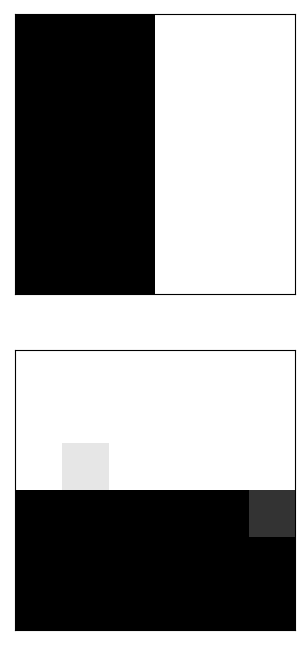

In [58]:
mante.psychometric_matrices(net_tmp, coherences=coherences)

Incredible! It appears that the almost 600 neurons of population 0 are doing NOTHING

In [59]:
# And inactivating population 1:
net_tmp = net_behav.clone()
with torch.no_grad():
    net_tmp.wi[:, z==1] = 0
    net_tmp.m[z==1] = 0
    net_tmp.n[z==1] = 0
loss, acc = mante.test_mante(net_tmp, inputs, targets_task, mask_task)
print(acc)

0.5


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

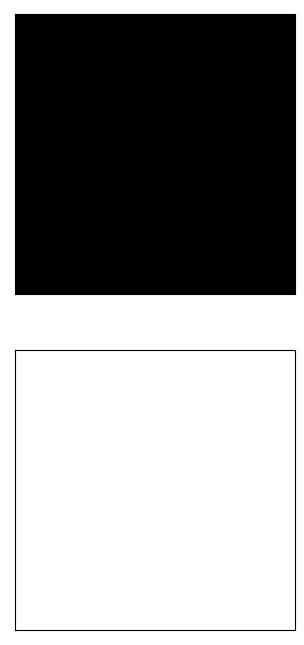

In [60]:
mante.psychometric_matrices(net_tmp, coherences=coherences)